#Membuat Model NLP dengan TensorFlow
Nama : Fajrinna Kasih Suci | Email Dicoding : fajrinnaks@gmail.com | Kelas : Machine Learning untuk pemula

**1. Import Library yang dibutuhkan**

In [35]:
#membaca file dataset
import pandas as pd

#import library untuk proses machine learning
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#library NLTK untuk membersihkan data teks
import nltk
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')

#untuk menampilkan grafik
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**2. Menyiapkan Dataset**

In [13]:
df = pd.read_csv('bbc-news-data.csv',sep='\t' )

In [14]:
df.tail()

,category,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


In [16]:
# Menghapus column yang tidak diperlukan
df=df.drop(columns=['filename','title']) 

In [17]:
df

,category,content
0,business,Quarterly profits at US media giant TimeWarne...
1,business,The dollar has hit its highest level against ...
2,business,The owners of embattled Russian oil giant Yuk...
3,business,British Airways has blamed high fuel prices f...
4,business,Shares in UK drinks and food firm Allied Dome...
...,...,...
2220,tech,BT is introducing two initiatives to help bea...
2221,tech,Computer users across the world continue to i...
2222,tech,A new European directive could put software w...
2223,tech,The man making sure US computer networks are ...


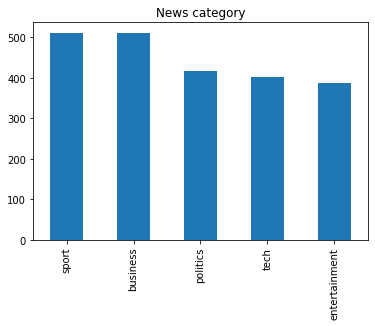

In [18]:
#melihat persebaran dari kolom 'category'
df['category'].value_counts().plot(kind='bar', title='News category')

**3. Cleaning text dengan ReGex**

In [19]:
import re
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [22]:
def clean_text(text):
    text = text.lower() # lowercase teks
    text = REPLACE_BY_SPACE_RE.sub(' ', text) #mengganti simbol yang termasuk REPLACE_BY_SPACE_RE pada tekslalu subsitusi dengan space
    text = BAD_SYMBOLS_RE.sub('', text) # hilangkan simbol2 yang merupakan BAD_SYMBOLS_RE lalu subsitusi dengan space
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [23]:
df['content'] = df['content'].apply(clean_text)

In [24]:
df['content'] # cek teks apakah sudah cleaned

0       quarterly profits us media giant timewarner ju...
1       dollar hit highest level euro almost three mon...
2       owners embattled russian oil giant yukos ask b...
3       british airways blamed high fuel prices 40 dro...
4       shares uk drinks food firm allied domecq risen...
                              ...                        
2220    bt introducing two initiatives help beat rogue...
2221    computer users across world continue ignore se...
2222    new european directive could put software writ...
2223    man making sure us computer networks safe secu...
2224    online role playing games timeconsuming enthra...
Name: content, Length: 2225, dtype: object

**4. melakukan one-hot-encoding dan membuat dataframe baru**

In [25]:
Y = pd.get_dummies(df['category'])
df_baru = pd.concat([df, Y], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,content,business,entertainment,politics,sport,tech
0,quarterly profits us media giant timewarner ju...,1,0,0,0,0
1,dollar hit highest level euro almost three mon...,1,0,0,0,0
2,owners embattled russian oil giant yukos ask b...,1,0,0,0,0
3,british airways blamed high fuel prices 40 dro...,1,0,0,0,0
4,shares uk drinks food firm allied domecq risen...,1,0,0,0,0
...,...,...,...,...,...,...
2220,bt introducing two initiatives help beat rogue...,0,0,0,0,1
2221,computer users across world continue ignore se...,0,0,0,0,1
2222,new european directive could put software writ...,0,0,0,0,1
2223,man making sure us computer networks safe secu...,0,0,0,0,1


In [27]:
# mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values
issues = df_baru['content'].values
label = df_baru[['business', 'tech', 'entertainment', 'politics', 'sport']].values

In [28]:
from sklearn.model_selection import train_test_split
issues_latih, issues_test, label_latih, label_test = train_test_split(issues, label, test_size=0.2)

In [30]:
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(issues_latih) 
tokenizer.fit_on_texts(issues_test)

issues_latih = tokenizer.texts_to_sequences(issues_latih)
issues_test = tokenizer.texts_to_sequences(issues_test)

padded_latih = pad_sequences(issues_latih) 
padded_test = pad_sequences(issues_test) 

**5. Lakukan LSTM** 

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#membuat arsitektur LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          80000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 16)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               46800     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 133,589
Trainable params: 133,589
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
history = model.fit(padded_latih, label_latih, epochs=10, batch_size=64,validation_split=0.2,
                    callbacks=[EarlyStopping(
                        monitor='val_loss', patience=3, min_delta=0.0001, verbose = 2)
                    ])

Epoch 1/10
23/23 [==============================] - 72s 3s/step - loss: 0.3488 - accuracy: 0.8455 - val_loss: 0.5920 - val_accuracy: 0.7528
Epoch 2/10
23/23 [==============================] - 63s 3s/step - loss: 0.3001 - accuracy: 0.8420 - val_loss: 0.6699 - val_accuracy: 0.7331
Epoch 3/10
23/23 [==============================] - 62s 3s/step - loss: 0.2264 - accuracy: 0.9213 - val_loss: 0.5235 - val_accuracy: 0.8287
Epoch 4/10
23/23 [==============================] - 63s 3s/step - loss: 0.1659 - accuracy: 0.9508 - val_loss: 0.5491 - val_accuracy: 0.8567
Epoch 5/10
23/23 [==============================] - 62s 3s/step - loss: 0.0860 - accuracy: 0.9789 - val_loss: 0.4451 - val_accuracy: 0.8596
Epoch 6/10
23/23 [==============================] - 62s 3s/step - loss: 0.0367 - accuracy: 0.9902 - val_loss: 0.5795 - val_accuracy: 0.8624
Epoch 7/10
23/23 [==============================] - 62s 3s/step - loss: 0.0727 - accuracy: 0.9775 - val_loss: 0.4746 - val_accuracy: 0.8539
Epoch 8/10
23/23 [==

**6.Melihat perbandingan akurasi dan loss antara test dan validation model dalam Grafik Plot**

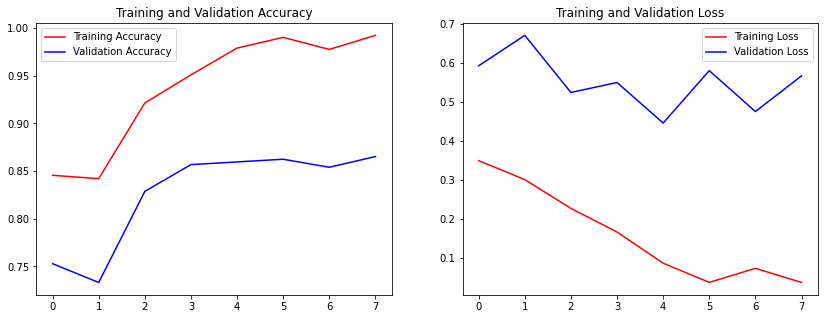

In [36]:
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
acc_plot, = plt.plot(epochs, acc, 'r')
val_acc_plot, = plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

# Loss plot
plt.subplot(1, 2, 2)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
loss_plot, = plt.plot(epochs, loss, 'r')
val_loss_plot, = plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])